# Sprint　ディープラーニングフレームワーク 2 
＜目的＞  
- フレームワークのコードを読めるようにする
- フレームワークを習得し続けられるようになる
- 理論を知っている範囲をフレームワークで動かす

＜異なるフレームワークへの書き換え＞  
「ディープラーニングフレームワーク1」で作成した4種類のデータセットを扱うTensorFLowのコードを異なるフレームワークに変更していきます。  

- Iris（Iris-versicolorとIris-virginicaのみの2値分類）
- Iris（3種類全ての目的変数を使用して多値分類）
- House Prices
- MNIST

＜Kerasへの書き換え＞  
KerasはTensorFLowに含まれるtf.kerasモジュールを使用してください。  
KerasにはSequentialモデルかFunctional APIかなど書き方に種類がありますが、これは指定しません。

In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import pandas as pd
import tensorflow as tf
tf.enable_eager_execution()
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
import warnings
import time
import os
matplotlib_style = 'fivethirtyeight' 
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize
notebook_screen_res = 'retina' 
%config InlineBackend.figure_format = notebook_screen_res
from sklearn.model_selection import train_test_split
from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from keras.datasets import mnist
from IPython.display import Image

Using TensorFlow backend.


### 【問題1】公式チュートリアルモデルを分担して実行  
TensorFLowの公式チュートリアルモデルを分担して実行してください。  
以下の中から1人ひとつ選び実行し、その結果を簡単に発表してください。

### 構造化されたデータの分類  
このチュートリアルでは、（例えばCSVファイルに保存された表形式データのような）構造化されたデータをどうやって分類するかを示します。ここでは、モデルの定義にKerasを、feature columnsをCSVファイルの列をモデルを訓練するための特徴量にマッピングするための橋渡し役として使用します。このチュートリアルには、下記のことを行うコードすべてが含まれています。

- Pandasを使用したCSVファイルの読み込み
- tf.dataを使用して行データをシャッフルし、バッチ化するための入力パイプライン構築
- feature columnsを使ったCSVの列のモデル訓練用の特徴量へのマッピング
- Kerasを使ったモデルの構築と、訓練及び評価

**＜データセット＞**  
ここでは、Cleveland Clinic Foundation for Heart Diseaseが提供している小さなデータセットを使用します。このCSVファイルには数百行が含まれています。行が患者を、列がその属性を表します。この情報を使用して、患者が心臓疾患を持っているかを予測します。このデータセットの場合には二値分類タスクとなります。

下記はこのデータセットの說明です。数値列とカテゴリー列があることに注目してください。

In [2]:
URL = 'https://storage.googleapis.com/applied-dl/heart.csv'
dataframe = pd.read_csv(URL)
dataframe.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


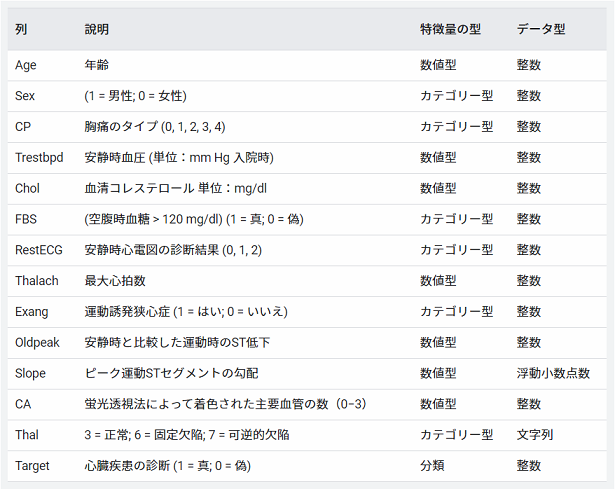

In [2]:
Image("fw-1.png")

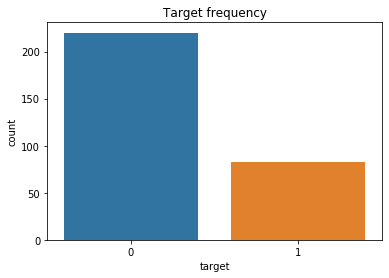

frequency :
0    220
1     83
Name: target, dtype: int64


In [4]:
# クラスごとのデータ数を描画
plt.title('Target frequency')
sns.countplot(x='target', data=dataframe)
plt.show()

print('frequency :\n{}'.format(dataframe['target'].value_counts()))

In [5]:
train, test = train_test_split(dataframe, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

193 train examples
49 validation examples
61 test examples


**＜tf.dataを使った入力パイプラインの構築＞**    
次に、``tf.data``を使ってデータフレームをラップします。こうすることで、feature columns をPandasデータフレームの列をモデル訓練用の特徴量へのマッピングするための橋渡し役として使うことができます。（メモリに収まらないぐらいの）非常に大きなCSVファイルを扱う場合には、``tf.data``を使ってディスクから直接CSVファイルを読み込むことになります。この方法は、このチュートリアルでは扱いません。

In [6]:
# Pandasデータフレームからtf.dataデータセットを作るためのユーティリティメソッド
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('target')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

**＜入力パイプラインを理解する＞**    
入力パイプラインを構築したので、それが返すデータのフォーマットを見るために呼び出してみましょう。出力を読みやすくするためにバッチサイズを小さくしてあります。

In [7]:
batch_size = 5 # デモ用として小さなバッチサイズを使用
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

type(train_ds)

tensorflow.python.data.ops.dataset_ops.DatasetV1Adapter

In [8]:
for feature_batch, label_batch in train_ds.take(1):
    print('Every feature:', list(feature_batch.keys()))
    print('A batch of ages:', feature_batch['age'])
    print('A batch of targets:', label_batch )

Every feature: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
A batch of ages: tf.Tensor([51 55 68 39 54], shape=(5,), dtype=int32)
A batch of targets: tf.Tensor([1 0 0 0 0], shape=(5,), dtype=int32)


データセットが（データフレームにある）列名からなるディクショナリを返すことがわかります。列名から、データフレームの行に含まれる列の値が得られます。

**＜feature columnsの様々な型の例＞**    
TensorFlowにはたくさんの型のfeature columnがあります。このセクションでは、いくつかの型のfeature columnsを作り、データフレームの列をどのように変換しているかを示します。

In [9]:
# いくつかの型のfeature columnsを例示するためこのバッチを使用する
example_batch = next(iter(train_ds))[0]

In [10]:
# feature columnsを作りデータのバッチを変換する
# ユーティリティメソッド
def demo(feature_column):
    feature_layer = layers.DenseFeatures(feature_column)
    np.set_printoptions(threshold=np.inf)
    print(feature_layer(example_batch).numpy())

**＜数値コラム＞**    
feature columnsの出力はモデルへの入力になります（上記で定義したdemo関数を使うと、データフレームの列がどのように変換されるかをつぶさに見ることができます）。**数値コラム**は、最も単純な型のコラムです。数値コラムは実数特徴量を表現するのに使われます。このコラムを使う場合、モデルにはデータフレームの列の値がそのまま渡されます。

In [11]:
age = feature_column.numeric_column("age")
demo(age)

[[51.]
 [55.]
 [68.]
 [39.]
 [54.]]


**＜バケット化コラム＞**  
数値をそのままモデルに入力するのではなく、値の範囲に基づいた異なるカテゴリーに分割したいことがあります。例えば、人の年齢を表す生データを考えてみましょう。バケット化コラムを使うと年齢を数値コラムとして表現するのではなく、年齢をいくつかのバケットに分割できます。下記のワンホット値が、各行がどの年齢範囲にあるかを表していることに注目してください。

In [12]:
age_buckets = feature_column.bucketized_column(age, boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])
demo(age_buckets)

[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


**＜カテゴリー型コラム＞**  
このデータセットでは、Thalは（'fixed'、'normal'、'reversible'のような）文字列として表現されています。文字列を直接モデルに入力することはできません。まず、文字列を数値にマッピングする必要があります。``categorical vocabulary`` コラムを使うと、（上記で示した年齢バケットのように）文字列をワンホットベクトルとして表現することができます。カテゴリーを表す語彙(vocabulary)は``categorical_column_with_vocabulary_list``を使ってリストで渡すか、``categorical_column_with_vocabulary_file``を使ってファイルから読み込むことができます。

In [15]:
thal = feature_column.categorical_column_with_vocabulary_list(
      'thal', ['fixed', 'normal', 'reversible'])

thal_one_hot = feature_column.indicator_column(thal)
demo(thal_one_hot)

[[0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


**＜埋め込み型コラム＞**  
数種類の候補となる文字列ではなく、カテゴリー毎に数千（あるいはそれ以上）の値があるとしましょう。カテゴリーの数が多くなってくると、様々な理由から、ワンホットエンコーディングを使ってニューラルネットワークを訓練することが難しくなります。埋込み型コラムを使うと、こうした制約を克服することが可能です。**埋込み型コラム**は、データを多次元のワンホットベクトルとして表すのではなく、セルの値が0か1かだけではなく、どんな数値でもとれるような密な低次元ベクトルとして表現します。埋め込みのサイズ（下記の例では8）は、チューニングが必要なパラメータです。

キーポイント：カテゴリー型コラムがたくさんの選択肢を持つ場合、埋め込み型コラムを使用することが最善の方法です。ここでは例を一つ示しますので、今後様々なデータセットを扱う際には、この例を参考にしてください。

In [16]:
# この埋込み型コラムの入力は、先程作成したカテゴリ型コラムであることに注意
thal_embedding = feature_column.embedding_column(thal, dimension=10)
demo(thal_embedding)

[[-0.1554551  -0.03983762  0.03380342 -0.4522901  -0.06906582  0.03437408
   0.1298561   0.41206813 -0.19267654  0.5870256 ]
 [ 0.0943989   0.3550063   0.53404164  0.08499756  0.5707749   0.25036398
   0.23528926 -0.00930188  0.35972062  0.1668428 ]
 [ 0.0943989   0.3550063   0.53404164  0.08499756  0.5707749   0.25036398
   0.23528926 -0.00930188  0.35972062  0.1668428 ]
 [ 0.0943989   0.3550063   0.53404164  0.08499756  0.5707749   0.25036398
   0.23528926 -0.00930188  0.35972062  0.1668428 ]
 [ 0.0943989   0.3550063   0.53404164  0.08499756  0.5707749   0.25036398
   0.23528926 -0.00930188  0.35972062  0.1668428 ]]


**＜ハッシュ化特徴コラム＞**  
値の種類が多いカテゴリー型コラムを表現するもう一つの方法が、``categorical_column_with_hash_bucket``を使う方法です。このfeature columnは文字列をエンコードするために入力のハッシュ値を計算し、``hash_bucket_size``個のバケットの中から1つを選択します。このコラムを使用する場合には、語彙を用意する必要はありません。また、スペースの節約のために、実際のカテゴリー数に比べて極めて少ないバケット数を選択することも可能です。

キーポイント：この手法の重要な欠点の一つは、異なる文字列が同じバケットにマッピングされるというハッシュ値の衝突が起きることです。実務上は、データセットによっては、この問題を無視できることがあります。

In [18]:
thal_hashed = feature_column.categorical_column_with_hash_bucket(
      'thal', hash_bucket_size=20)
demo(feature_column.indicator_column(thal_hashed))

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


**＜クロスフィーチャーコラム＞**  
複数の特徴量をまとめて1つの特徴量にする、フィーチャークロスとして知られている手法は、モデルが特徴量の組み合わせの一つ一つに別々の重みを学習することを可能にします。ここでは年齢とThalをクロスさせて新しい特徴量を作ってみます。交差列(``crossed_column``)が、起こりうるすべての組み合わせ全体のテーブル（これは非常に大きくなる可能性があります）を作るものではないことに注意してください。クロスフィーチャーコラムは、代わりにバックエンドとしてハッシュ化コラムを使用しているため、テーブルの大きさを選択することができます。

In [20]:
crossed_feature = feature_column.crossed_column([age_buckets, thal], hash_bucket_size=16)
demo(feature_column.indicator_column(crossed_feature))

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


**＜使用するコラムを選択する＞**  
これまで、いくつかのfeature columnの使い方を見てきました。いよいよモデルの訓練にそれらを使用することにします。このチュートリアルの目的は、feature columnsを使うのに必要な完全なコード（いわば力学）を示すことです。以下ではモデルを訓練するための列を適当に選びました。

In [21]:
feature_columns = []

# 数値コラム
for header in ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'slope', 'ca']:
    feature_columns.append(feature_column.numeric_column(header))

# バケット化コラム
age_buckets = feature_column.bucketized_column(age, boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])
feature_columns.append(age_buckets)

# インジケーター（カテゴリー型）コラム
thal = feature_column.categorical_column_with_vocabulary_list(
      'thal', ['fixed', 'normal', 'reversible'])
thal_one_hot = feature_column.indicator_column(thal)
feature_columns.append(thal_one_hot)

# 埋め込み型コラム
thal_embedding = feature_column.embedding_column(thal, dimension=8)
feature_columns.append(thal_embedding)

# クロスフィーチャーコラム
crossed_feature = feature_column.crossed_column([age_buckets, thal], hash_bucket_size=1000)
crossed_feature = feature_column.indicator_column(crossed_feature)
feature_columns.append(crossed_feature)

In [22]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [23]:
batch_size = 32
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

**＜モデルの構築、コンパイルと訓練＞**

In [24]:
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(train_ds, 
          validation_data=val_ds, 
          epochs=5)

Epoch 1/5
7/7 [==============================] - 2s 251ms/step - loss: 2.7564 - acc: 0.5699 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/5
7/7 [==============================] - 0s 8ms/step - loss: 0.9729 - acc: 0.5803 - val_loss: 0.4427 - val_acc: 0.7347
Epoch 3/5
7/7 [==============================] - 0s 8ms/step - loss: 0.8082 - acc: 0.7150 - val_loss: 0.6416 - val_acc: 0.7551
Epoch 4/5
7/7 [==============================] - 0s 8ms/step - loss: 0.6848 - acc: 0.7098 - val_loss: 0.4002 - val_acc: 0.7551
Epoch 5/5
7/7 [==============================] - 0s 8ms/step - loss: 0.5605 - acc: 0.7461 - val_loss: 0.6498 - val_acc: 0.7551


In [25]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

2/2 [==============================] - 0s 4ms/step - loss: 0.3846 - acc: 0.8197
Accuracy 0.8196721


**＜次のステップ＞**  
構造化データの分類について更に多くのことを学ぶためには、自分自身で試してみることです。別のデータセットを見つけ、上記と同様のコードを使って、それを分類するモデルを訓練してみてください。正解率を上げるためには、モデルにどの特徴量を含めたらよいかや、その特徴量をどのように表現すべきかをじっくり考えてください。

### 【問題2】様々な手法を実行  
TensorFLowやGoogle AI ResearchのGitHubリポジトリには、定番のモデルから最新のモデルまで多様なコードが公開されています。これらから興味あるものを選び実行してください。  
なお、これらのコードは初学者向けではないため、巨大なデータセットのダウンロードが必要な場合など、実行が簡単ではないこともあります。そういった場合は、コードリーディングを行ってください。  
更新日が古いものはPythonやTensorFlowのバージョンが古く、扱いずらい場合があります。新しいものから見ることを推奨します。

### 確率的プログラミングの概要  
TensorFLowやGoogle AI ResearchのGitHubリポジトリにアップロードされている内容ではないが、TensorFlow Blogにて上記の内容を紹介していたので、興味のあるものとして取り上げる。

### ＜概要＞  
確率的プログラミングはベイズ推定の理念に則っている。

＜ベイズ推定法＞  
ベイズ確率の考え方に基づき、観測事象（観測された事実）から、推定したい事柄（それの起因である原因事象）を、確率的な意味で推論することを指す。ベイズ推定においては、パラメータ $\theta$ の点推定を求めることは、ベイズ確率（分布関数）を求めた後に、決められた汎関数：$p(\theta )\rightarrow {\hat  {\theta }}$ の値（平均値もしくは中央値など）を派生的に計算することと見做される。

現実世界の現象は、理論が完全にわかっているものであっても、制御できない外的要因の影響から、不確実性を含んでいる。従来の統計学では、ある事象が起こる確率を不変のものとしてとらえるが、ベイズ推定では「事前確率を観測（情報）によって事後確率へとベイズ更新し、より正確なものへ近づける」という理念がある。

TnsorFlow Probability（以下TFP）は、この確率的アプローチと深層学習とを組み合わせる事を容易にするPythonライブラリである。入門的なチュートリアルが紹介されていたので、以下で実行してみる。

### ＜1986年　スペースシャトル　チャレンジャー号の事故＞  
上記の事故は、2つの固形ロケットブースターの1つが、使用されていたOリングの故障により爆発したことが原因であった。技術者はOリングの製造元と頻繁に連絡を取り合っていたが、製造元は故障のリスクを許容できるものとしていた。

以下に、以前の7つのシャトルミッションでのOリング損傷事象を、周辺温度の関数として表す。

In [12]:
 
def evaluate(tensors):
    if tf.executing_eagerly():
        return tf.contrib.framework.nest.pack_sequence_as(
            tensors,
            [t.numpy() if tf.contrib.framework.is_tensor(t) else t
             for t in tf.contrib.framework.nest.flatten(tensors)])
    return sess.run(tensors)

class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()


def session_options(enable_gpu_ram_resizing=True, enable_xla=True):
    """
    Allowing the notebook to make use of GPUs if they're available.
    
    XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear 
    algebra that optimizes TensorFlow computations.
    """
    config = tf.ConfigProto()
    config.log_device_placement = True
    if enable_gpu_ram_resizing:
        # `allow_growth=True` makes it possible to connect multiple colabs to your
        # GPU. Otherwise the colab malloc's all GPU ram.
        config.gpu_options.allow_growth = True
    if enable_xla:
        # Enable on XLA. https://www.tensorflow.org/performance/xla/.
        config.graph_options.optimizer_options.global_jit_level = (
            tf.OptimizerOptions.ON_1)
    return config


def reset_sess(config=None):
    """
    Convenience function to create the TF graph & session or reset them.
    """
    if config is None:
        config = session_options()
    global sess
    tf.reset_default_graph()
    try:
        sess.close()
    except:
        pass
    sess = tf.InteractiveSession(config=config)

reset_sess()

Device mapping:



In [27]:
import requests
url = 'https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter2_MorePyMC/data/challenger_data.csv'
r = requests.get(url)
with open('challenger_data.csv', mode='w') as f:
    f.write(r.text)

Temp (F), O-Ring failure?
[[66.  0.]
 [70.  1.]
 [69.  0.]
 [68.  0.]
 [67.  0.]
 [72.  0.]
 [73.  0.]
 [70.  0.]
 [57.  1.]
 [63.  1.]
 [70.  1.]
 [78.  0.]
 [67.  0.]
 [53.  1.]
 [67.  0.]
 [75.  0.]
 [70.  0.]
 [81.  0.]
 [76.  0.]
 [79.  0.]
 [75.  1.]
 [76.  0.]
 [58.  1.]]


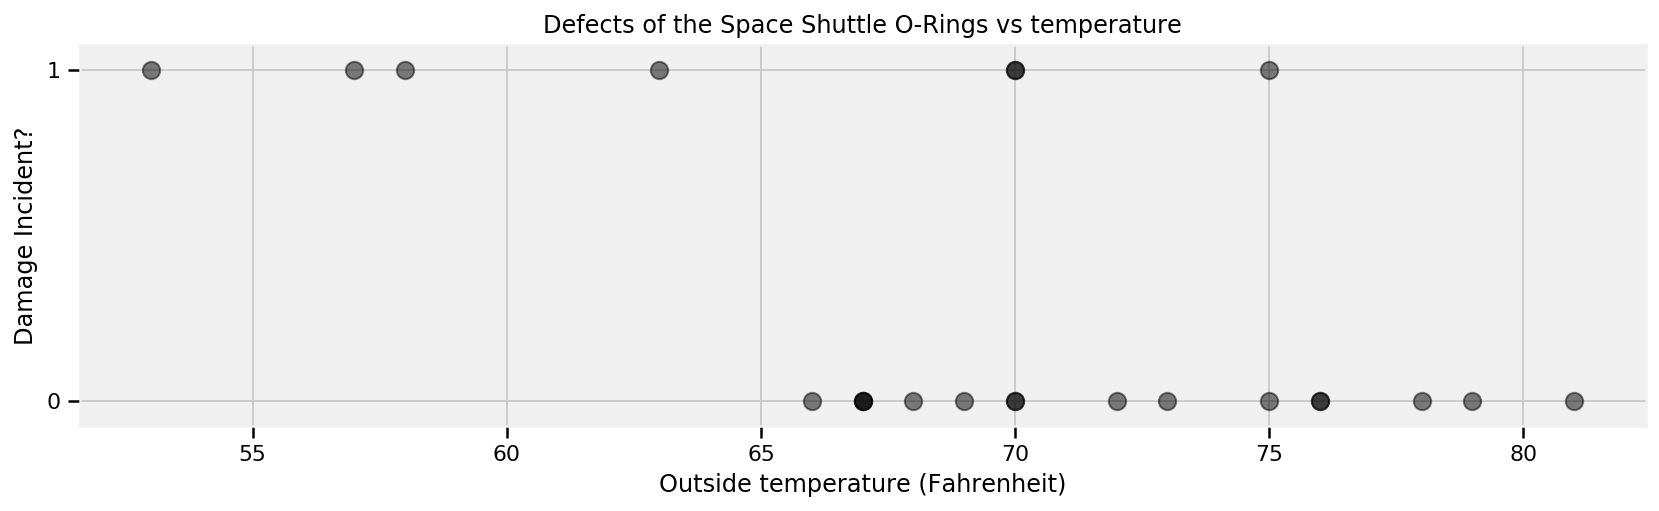

In [5]:
plt.figure(figsize(12.5, 3.5))
np.set_printoptions(precision=3, suppress=True)
challenger_data_ = np.genfromtxt("challenger_data.csv", skip_header=1,
                                usecols=[1, 2], missing_values="NA",
                                delimiter=",")
#drop the NA values
challenger_data_ = challenger_data_[~np.isnan(challenger_data_[:, 1])]

#plot it, as a function of tempature (the first column)
print("Temp (F), O-Ring failure?")
print(challenger_data_)

plt.scatter(challenger_data_[:, 0], challenger_data_[:, 1], s=75, color="k",
            alpha=0.5)
plt.yticks([0, 1])
plt.ylabel("Damage Incident?")
plt.xlabel("Outside temperature (Fahrenheit)")
plt.title("Defects of the Space Shuttle O-Rings vs temperature");

温度が低いほどOリングが損傷する傾向があるが、明確な閾値を示すことはできない。このように現実の現象には不確実性が伴うため、特定の温度の条件下でOリングが損傷する確率を推定していく。

### ＜確率モデル構築＞

ロジスティック関数を用いて、温度 $t$ でのリング損傷確率 $p$ を以下のようにモデル化できる。

$$
p(t)=\frac{1}{1+e^{{\beta}t+\alpha}}
$$

ここで使用しているパラメーター $\beta$, $\alpha$ はいずれも、正規分布に従う確率変数としてモデル化できる。

$$
\beta=Normal(\mu,\sigma^2) \;\;\;\\
\alpha=Normal(\mu,\sigma^2)
$$

$\alpha$, $\beta$の値により、仮説のsigmoid曲線は以下のように変化する。

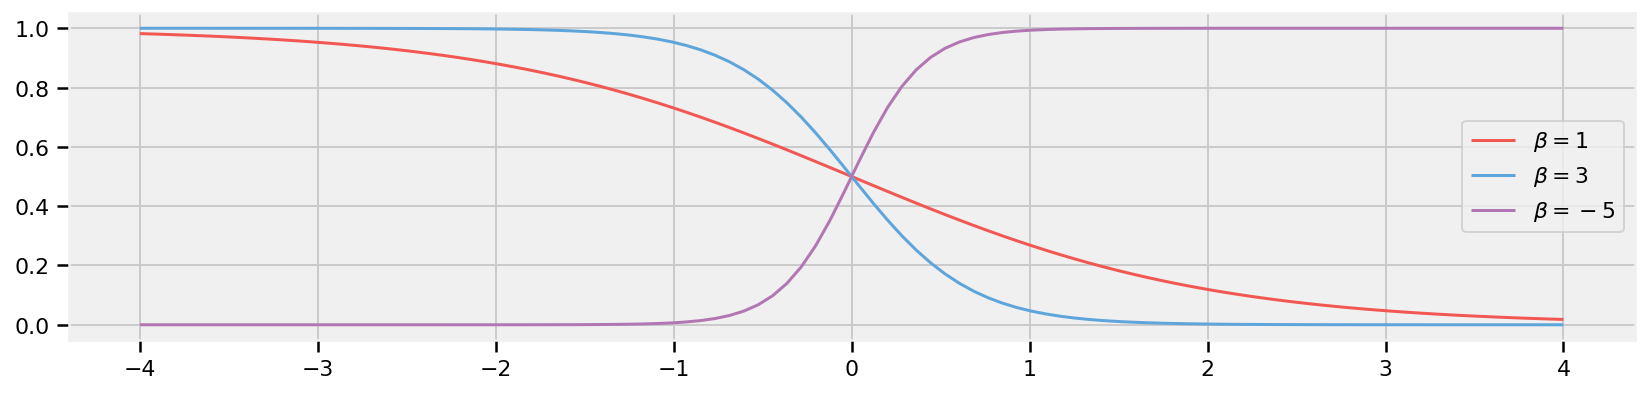

In [7]:
def logistic(x, beta):
    """
    Logistic Function
        
    Args:
      x: independent variable
      beta: beta term
    Returns: 
      Logistic function
    """
    return 1.0 / (1.0 + tf.exp(beta * x))

x_vals = tf.linspace(start=-4., stop=4., num=100)
log_beta_1 = logistic(x_vals, 1.)
log_beta_3 = logistic(x_vals, 3.)
log_beta_m5 = logistic(x_vals, -5.)

[
    x_vals_,
    log_beta_1_,
    log_beta_3_,
    log_beta_m5_,
] = evaluate([
    x_vals,
    log_beta_1,
    log_beta_3,
    log_beta_m5,
])

plt.figure(figsize(12.5, 3))
plt.plot(x_vals_, log_beta_1_, label=r"$\beta = 1$", color=TFColor[0])
plt.plot(x_vals_, log_beta_3_, label=r"$\beta = 3$", color=TFColor[3])
plt.plot(x_vals_, log_beta_m5_, label=r"$\beta = -5$", color=TFColor[6])
plt.legend();


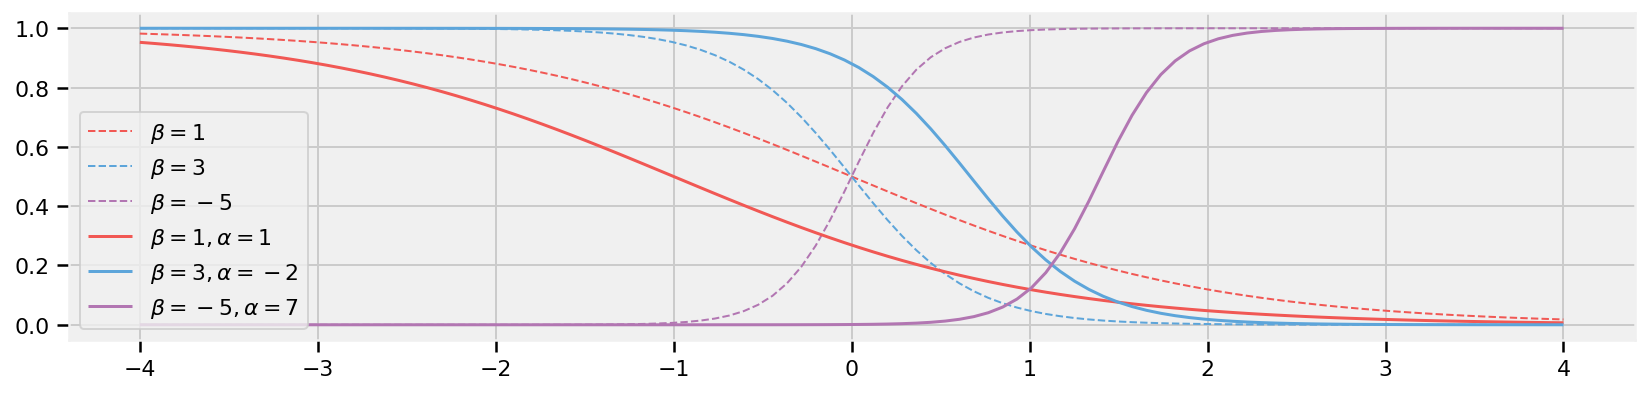

In [8]:
def logistic(x, beta, alpha=0):
    """
    Logistic Function with offset
        
    Args:
        x: independent variable
        beta: beta term 
        alpha: alpha term
    Returns: 
        Logistic function
    """
    return 1.0 / (1.0 + tf.exp((beta * x) + alpha))

x_vals = tf.linspace(start=-4., stop=4., num=100)
log_beta_1_alpha_1 = logistic(x_vals, 1, 1)
log_beta_3_alpha_m2 = logistic(x_vals, 3, -2)
log_beta_m5_alpha_7 = logistic(x_vals, -5, 7)

[
    x_vals_,
    log_beta_1_alpha_1_,
    log_beta_3_alpha_m2_,
    log_beta_m5_alpha_7_,
] = evaluate([
    x_vals,
    log_beta_1_alpha_1,
    log_beta_3_alpha_m2,
    log_beta_m5_alpha_7,
])

plt.figure(figsize(12.5, 3))
plt.plot(x_vals_, log_beta_1_, label=r"$\beta = 1$", ls="--", lw=1, color=TFColor[0])
plt.plot(x_vals_, log_beta_3_, label=r"$\beta = 3$", ls="--", lw=1, color=TFColor[3])
plt.plot(x_vals_, log_beta_m5_, label=r"$\beta = -5$", ls="--", lw=1, color=TFColor[6])
plt.plot(x_vals_, log_beta_1_alpha_1_, label=r"$\beta = 1, \alpha = 1$", color=TFColor[0])
plt.plot(x_vals_, log_beta_3_alpha_m2_, label=r"$\beta = 3, \alpha = -2$", color=TFColor[3])
plt.plot(x_vals_, log_beta_m5_alpha_7_, label=r"$\beta = -5, \alpha = 7$", color=TFColor[6])
plt.legend(loc="lower left");

故障の有無はコイン投げと同様の二値問題であり、温度 $t$ での故障確率 $p(t)$ はベルヌーイ分布に従うと考えられる。この分布に従う確率を変数を $Ber(p)$ として、上記の問題は最終的に以下のようにモデル化できる。

$$
D_i=ber(p(t_i)),\:i=1,..N
$$

このモデルを前提とし、観測データをうまく説明するパラメーターをベイズ推定を用いて推定していく。これが確率論的推定の目標である。

上記の内容を、TFPを用いて以下のように定義する。

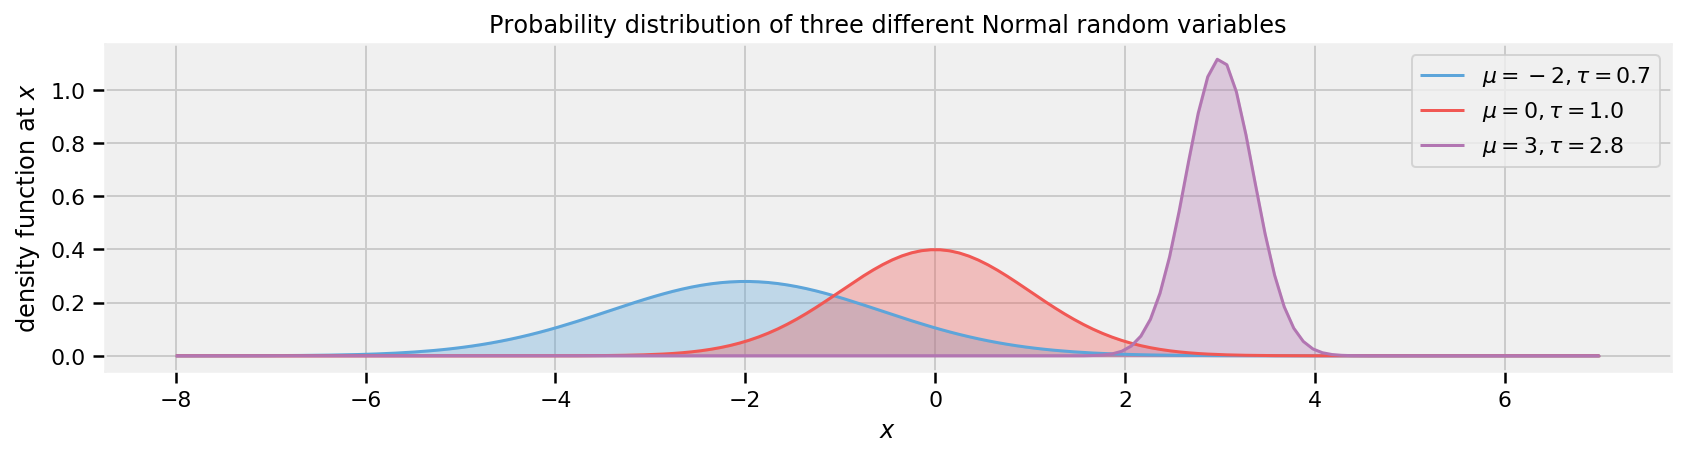

In [9]:
rand_x_vals = tf.linspace(start=-8., stop=7., num=150)

density_func_1 = tfd.Normal(loc=float(-2.), scale=float(1./.7)).prob(rand_x_vals)
density_func_2 = tfd.Normal(loc=float(0.), scale=float(1./1)).prob(rand_x_vals)
density_func_3 = tfd.Normal(loc=float(3.), scale=float(1./2.8)).prob(rand_x_vals)

[
    rand_x_vals_,
    density_func_1_,
    density_func_2_,
    density_func_3_,
] = evaluate([
    rand_x_vals,
    density_func_1,
    density_func_2,
    density_func_3,
])

colors = [TFColor[3], TFColor[0], TFColor[6]]

plt.figure(figsize(12.5, 3))
plt.plot(rand_x_vals_, density_func_1_,
         label=r"$\mu = %d, \tau = %.1f$" % (-2., .7), color=TFColor[3])
plt.fill_between(rand_x_vals_, density_func_1_, color=TFColor[3], alpha=.33)
plt.plot(rand_x_vals_, density_func_2_, 
         label=r"$\mu = %d, \tau = %.1f$" % (0., 1), color=TFColor[0])
plt.fill_between(rand_x_vals_, density_func_2_, color=TFColor[0], alpha=.33)
plt.plot(rand_x_vals_, density_func_3_,
         label=r"$\mu = %d, \tau = %.1f$" % (3., 2.8), color=TFColor[6])
plt.fill_between(rand_x_vals_, density_func_3_, color=TFColor[6], alpha=.33)

plt.legend(loc=r"upper right")
plt.xlabel(r"$x$")
plt.ylabel(r"density function at $x$")
plt.title(r"Probability distribution of three different Normal random variables");

In [13]:
reset_sess()

temperature_ = challenger_data_[:, 0]
temperature = tf.convert_to_tensor(temperature_, dtype=tf.float32)
D_ = challenger_data_[:, 1]                # defect or not?
D = tf.convert_to_tensor(D_, dtype=tf.float32)

beta = tfd.Normal(name="beta", loc=0.3, scale=1000.).sample()
alpha = tfd.Normal(name="alpha", loc=-15., scale=1000.).sample()
p_deterministic = tfd.Deterministic(name="p", loc=1.0/(1. + tf.exp(beta * temperature_ + alpha))).sample()

[
    prior_alpha_,
    prior_beta_,
    p_deterministic_,
    D_,
] = evaluate([
    alpha,
    beta,
    p_deterministic,
    D,
])

Device mapping:



In [14]:
def challenger_joint_log_prob(D, temperature_, alpha, beta):
    rv_alpha = tfd.Normal(loc=0., scale=1000.)
    rv_beta = tfd.Normal(loc=0., scale=1000.)

    # make this into a logit
    logistic_p = 1.0/(1. + tf.exp(beta * tf.to_float(temperature_) + alpha))
    rv_observed = tfd.Bernoulli(probs=logistic_p)
    
    return (
        rv_alpha.log_prob(alpha)
        + rv_beta.log_prob(beta)
        + tf.reduce_sum(rv_observed.log_prob(D))
    )

``rv_alpha``, ``rv_beta``はαとβの事前分布に基づく確率変数を表す。  
対して、``rv_observed``はαとβによって決定されるロジスティック回帰により、温度とOリング故障の尤度の事後確率の分布を表す。


### ＜マルコフ過程モンテカルロ法＞
次に``joint_log_prob``関数を``tfp.mcmc``モジュールに送る。mcmcは Markov chain Monte Carlo (MCMC) 法のことで、概念としては、乱数で発生させたパラメーターをもとに事後分布を推定し、観測結果と比較してより適切なパラメーターの分布を構築していくものである。

In [16]:
number_of_steps = 10000 
burnin = 2000 

initial_chain_state = [
    0. * tf.ones([], dtype=tf.float32, name="init_alpha"),
    0. * tf.ones([], dtype=tf.float32, name="init_beta")
]

unconstraining_bijectors = [
    tfp.bijectors.AffineScalar(100.),
    tfp.bijectors.Identity()
]

unnormalized_posterior_log_prob = lambda *args: challenger_joint_log_prob(D, temperature_, *args)

with tf.variable_scope(tf.get_variable_scope(), reuse=tf.AUTO_REUSE):
    step_size = tf.get_variable(
        name='step_size',
        initializer=tf.constant(0.01, dtype=tf.float32),
        trainable=False,
        use_resource=True
    )

hmc=tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        num_leapfrog_steps=40, #to improve convergence
        step_size=step_size,
        step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(
            num_adaptation_steps=int(burnin * 0.8)),
        state_gradients_are_stopped=True),
    bijector=unconstraining_bijectors)

[
    posterior_alpha,
    posterior_beta
], kernel_results = tfp.mcmc.sample_chain(
    num_results = number_of_steps,
    num_burnin_steps = burnin,
    current_state=initial_chain_state,
    kernel=hmc)

init_g = tf.global_variables_initializer()

C:\Users\USER\anaconda3\envs\tf115\lib\site-packages\tensorflow_probability\python\mcmc\sample.py:336: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


最後に、elauate()関数を使用して、実際に推論を実行する。

In [17]:
evaluate(init_g)
[
    posterior_alpha_,
    posterior_beta_,
    kernel_results_
] = evaluate([
    posterior_alpha,
    posterior_beta,
    kernel_results
])
    
print("acceptance rate: {}".format(
    kernel_results_.inner_results.is_accepted.mean()))
print("final step size: {}".format(
    kernel_results_.inner_results.extra.step_size_assign[-100:].mean()))

acceptance rate: 0.3142
final step size: 0.015187901444733143


### ＜結果の解釈＞

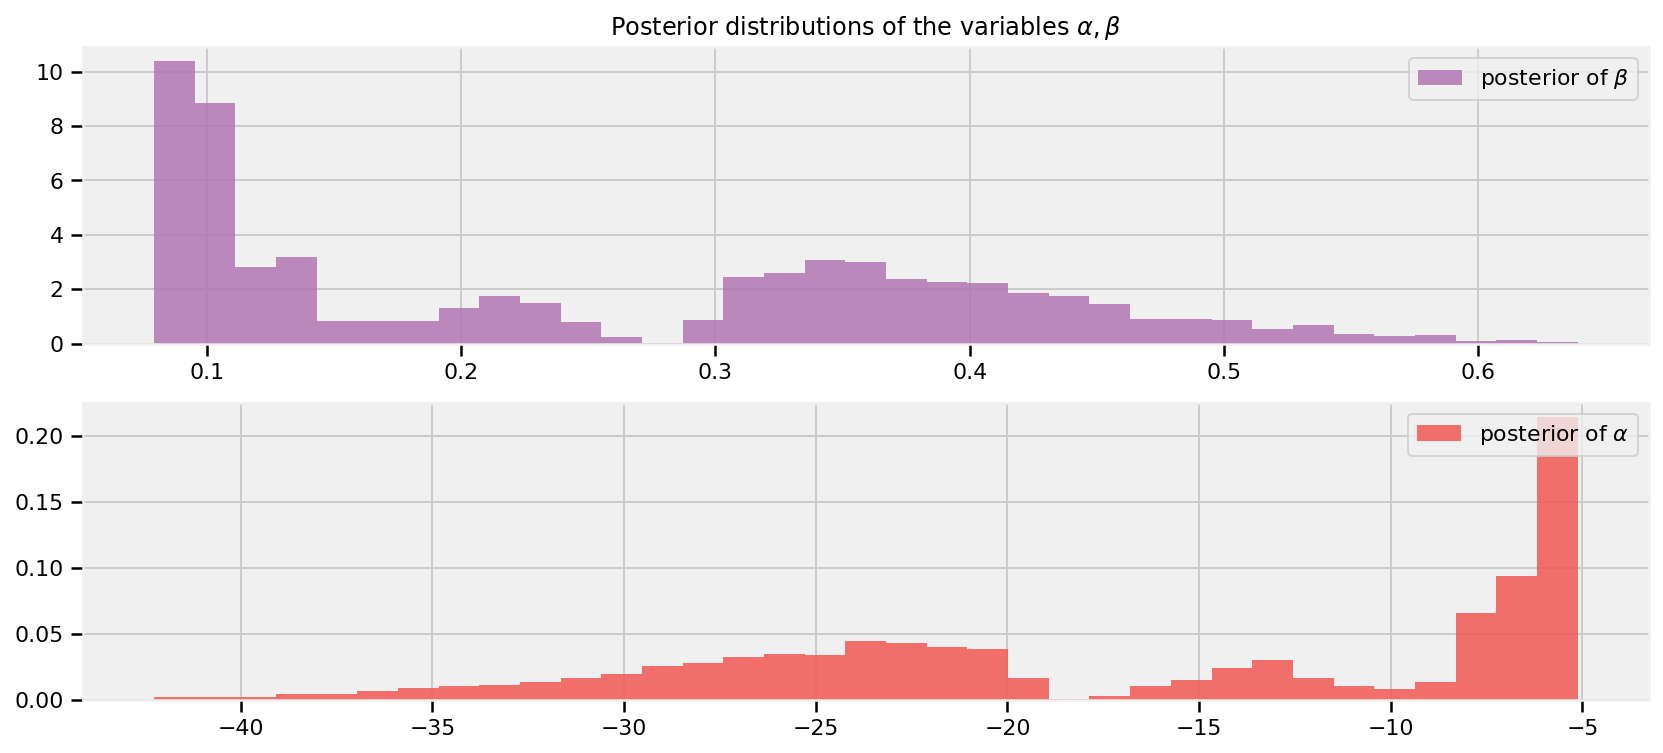

In [18]:
plt.figure(figsize(12.5, 6))

#histogram of the samples:
plt.subplot(211)
plt.title(r"Posterior distributions of the variables $\alpha, \beta$")
plt.hist(posterior_beta_, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\beta$", color=TFColor[6], density=True)
plt.legend()

plt.subplot(212)
plt.hist(posterior_alpha_, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\alpha$", color=TFColor[0], density=True)
plt.legend();

チュートリアルの結果（↓）とは異なるが、大筋は一致している

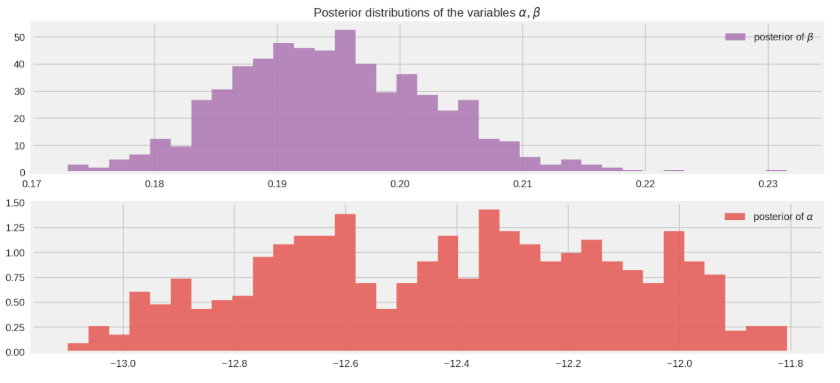

In [4]:
Image('fw-6.png')

αとβの分布をプロットすると、分布がかなり広く故障と非故障の温度帯が重なっていることを反映している。しかし、βの分布は全て0より大きく、温度が実際にOリングの損傷確率に影響を与えるとかなり確信できる。またαは全て負の領域に分布し、0を大幅に下回ると確信できる。  

特定の温度でOリングが損傷する確率を計算するには、事後の全てのサンプルを平均し、$p(t_i)$のとりうる値を取得する。

In [19]:
alpha_samples_1d_ = posterior_alpha_[:, None]  # best to make them 1d
beta_samples_1d_ = posterior_beta_[:, None]

beta_mean = tf.reduce_mean(beta_samples_1d_.T[0])
alpha_mean = tf.reduce_mean(alpha_samples_1d_.T[0])
[ beta_mean_, alpha_mean_ ] = evaluate([ beta_mean, alpha_mean ])


print("beta mean:", beta_mean_)
print("alpha mean:", alpha_mean_)

def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + tf.exp((beta * x) + alpha))

t_ = np.linspace(temperature_.min() - 5, temperature_.max() + 5, 2500)[:, None]
p_t = logistic(t_.T, beta_samples_1d_, alpha_samples_1d_)
mean_prob_t = logistic(t_.T, beta_mean_, alpha_mean_)
[ 
    p_t_, mean_prob_t_
] = evaluate([ 
    p_t, mean_prob_t
])

beta mean: 0.25399828
alpha mean: -16.517298


これで、温度の範囲全体にわたり $p(t)$ が95%の信頼度でとりうる範囲を計算できる。（統計検定での95%信頼区間とは異なる）  
例えば、以下のグラフで温度が50度のとき、Oリング故障の確率は95%の信頼度で0.60～1.0の間に入る。

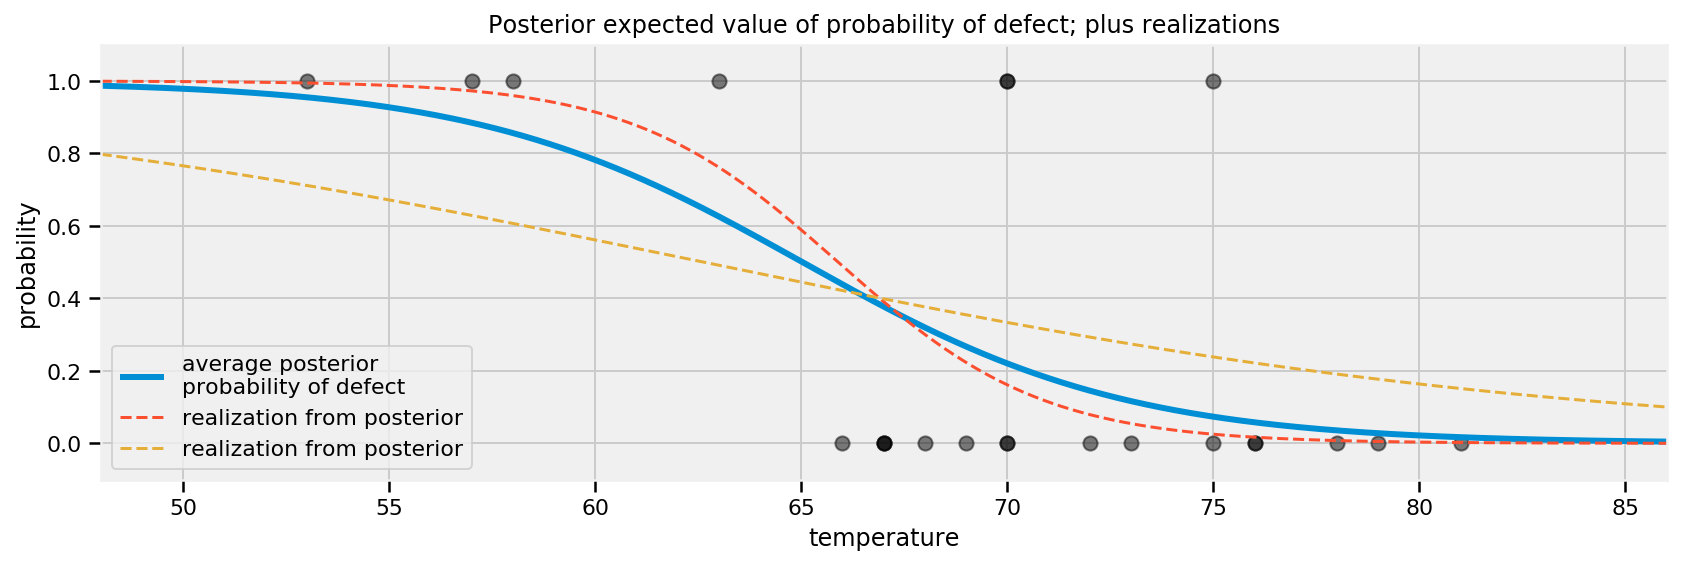

In [20]:
plt.figure(figsize(12.5, 4))

plt.plot(t_, mean_prob_t_.T, lw=3, label="average posterior \nprobability \
of defect")
plt.plot(t_, p_t_.T[:, 0], ls="--", label="realization from posterior")
plt.plot(t_, p_t_.T[:, -8], ls="--", label="realization from posterior")
plt.scatter(temperature_, D_, color="k", s=50, alpha=0.5)
plt.title("Posterior expected value of probability of defect; \
plus realizations")
plt.legend(loc="lower left")
plt.ylim(-0.1, 1.1)
plt.xlim(t_.min(), t_.max())
plt.ylabel("probability")
plt.xlabel("temperature");

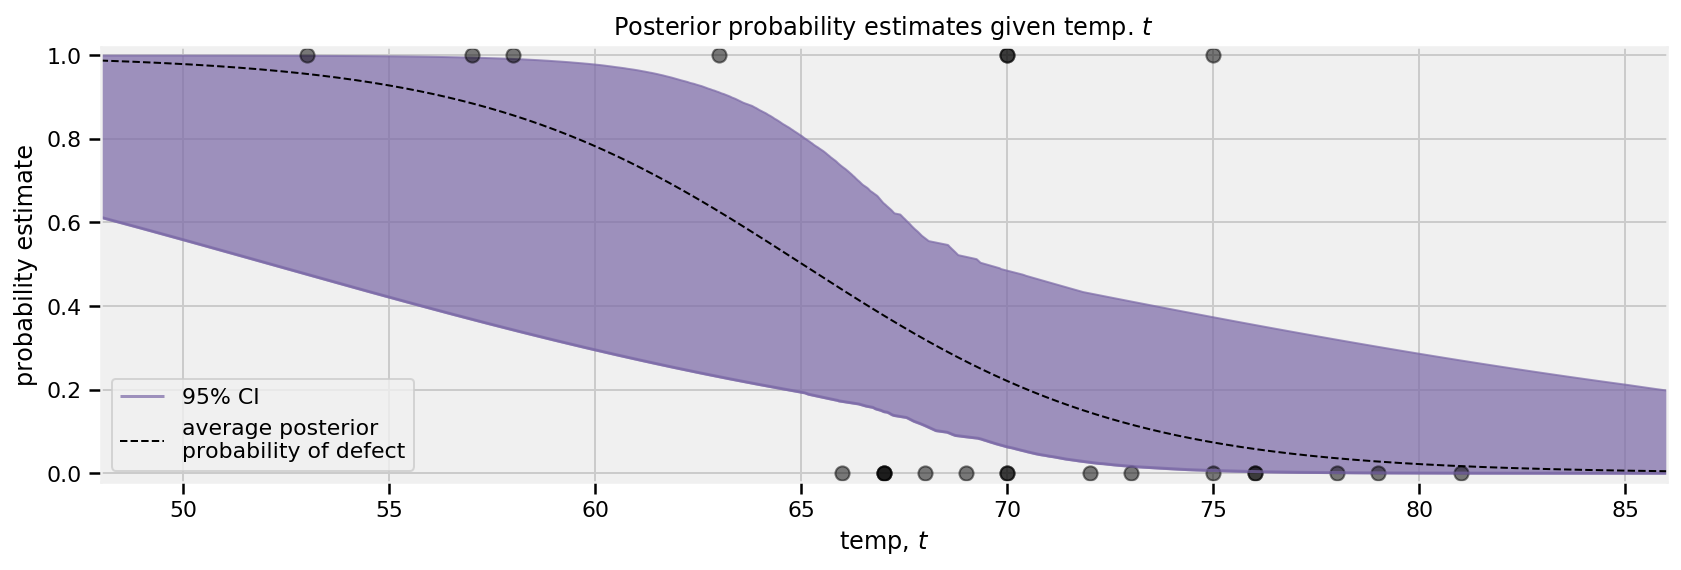

In [21]:
from scipy.stats.mstats import mquantiles

# vectorized bottom and top 2.5% quantiles for "confidence interval"
qs = mquantiles(p_t_, [0.025, 0.975], axis=0)
plt.fill_between(t_[:, 0], *qs, alpha=0.7,
                 color="#7A68A6")

plt.plot(t_[:, 0], qs[0], label="95% CI", color="#7A68A6", alpha=0.7)

plt.plot(t_[:, 0], mean_prob_t_[0,:], lw=1, ls="--", color="k",
         label="average posterior \nprobability of defect")

plt.xlim(t_.min(), t_.max())
plt.ylim(-0.02, 1.02)
plt.legend(loc="lower left")
plt.scatter(temperature_, D_, color="k", s=50, alpha=0.5)
plt.xlabel("temp, $t$")

plt.ylabel("probability estimate")
plt.title("Posterior probability estimates given temp. $t$");

チュートリアルの結果（↓）とは異なるが、妥当な印象

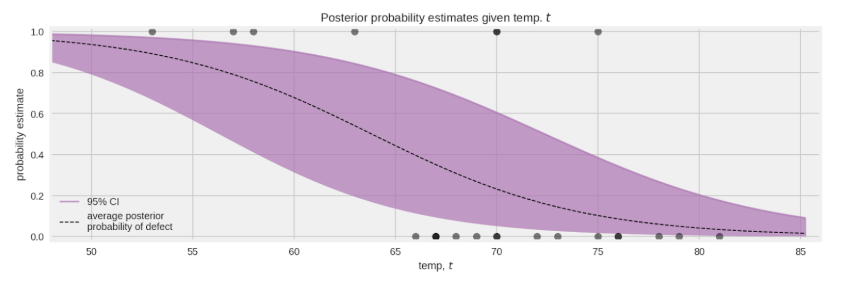

In [6]:
Image('fw-7.png')

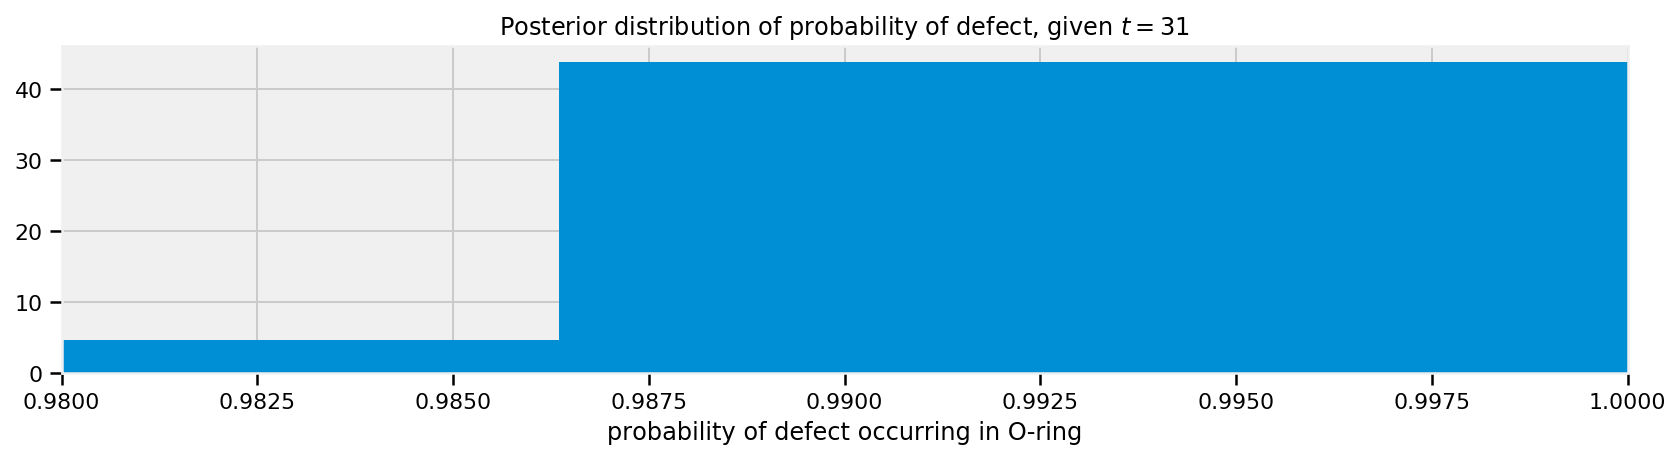

In [22]:
plt.figure(figsize(12.5, 3))

prob_31 = logistic(31, posterior_beta_, posterior_alpha_)

[ prob_31_ ] = evaluate([ prob_31 ])

plt.xlim(0.98, 1)
plt.hist(prob_31_, bins=10, density=True, histtype='stepfilled')
plt.title("Posterior distribution of probability of defect, given $t = 31$")
plt.xlabel("probability of defect occurring in O-ring");

チュートリアルの結果（↓）とは異なるが、妥当な印象

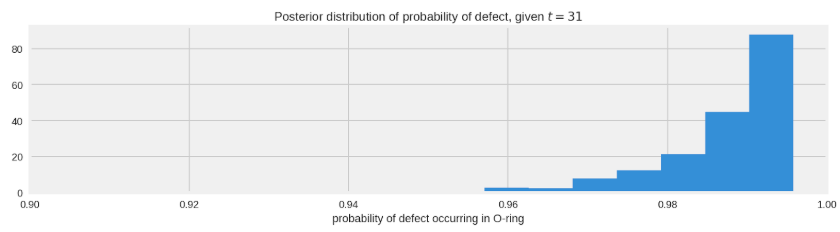

In [7]:
Image('fw-8.png')

チャレンジャー号の事故当日は31度であり、Oリングが故障する確率の事後分布は、高い確信をもって問題が発生するであろうと結論づけることができる。  

この単純な確率的分析は、TFPおよびベイズ推定法の威力を示している。これらの手法を活用し、現実世界の事象から重要な洞察と予測を得ることができる。

### 【問題3】Iris（2値分類）をKerasで学習  
TensorFlowによるIrisデータセットに対する2値分類をKerasに書き換えてください。

In [42]:
# データセットの読み込み
dataset_path ="Iris.csv"
df = pd.read_csv(dataset_path)
# データフレームから条件抽出
df = df[(df["Species"] == "Iris-versicolor")|(df["Species"] == "Iris-virginica")]
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)
# ラベルを数値に変換
y[y=='Iris-versicolor'] = 0
y[y=='Iris-virginica'] = 1
y = y.astype(np.int)[:, np.newaxis]

# 層化を有効にしてtrainとtestに分割
# 後にPytorchで使用するので番号もふる
X1_train, X1_test, y1_train, y1_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=y)
# さらにtrainとvalに分割
X1_train, X1_val, y1_train, y1_val = train_test_split(
    X1_train, y1_train, test_size=0.2, random_state=0, stratify=y1_train)

# 特徴量は標準化する
sc = StandardScaler()
# トレーニングデータから平均・標準偏差を計算
sc.fit(X1_train)
# 上記を用いて標準化
X1_train_std = sc.transform(X1_train)
X1_val_std = sc.transform(X1_val)
X1_test_std = sc.transform(X1_test)

X_train_std = X1_train_std
X_val_std = X1_val_std
X_test_std = X1_test_std
y_train = y1_train
y_val = y1_val
y_test = y1_test

# データの確認
print('X', X_train_std[:3])
print('X.shape', X_train_std.shape)
print('\ny', y_train[:3])
print('y.shape', y_train.shape)

X [[ 0.981  0.863  0.623  1.019]
 [ 0.674  0.538  0.375  1.496]
 [-0.707 -0.437 -0.992 -1.6  ]]
X.shape (64, 4)

y [[1]
 [1]
 [0]]
y.shape (64, 1)


In [45]:
# Kerasでモデル構築
input_data = tf.keras.layers.Input(shape=(4,))
x = tf.keras.layers.Dense(50, activation=tf.nn.relu)(input_data)
x = tf.keras.layers.Dense(100, activation=tf.nn.relu)(x)
output = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)(x)
model = tf.keras.Model(inputs=input_data, outputs=output)

In [46]:
# 訓練データで学習
t1 = time.time()
model.summary()
model.compile(loss='binary_crossentropy',
              optimizer=tf.train.AdamOptimizer(learning_rate=0.01),
              metrics=['accuracy'])
history = model.fit(X_train_std, y_train,
                    batch_size=10,
                    epochs=10,
                    verbose=1)
# 検証データで評価
loss, acc = model.evaluate(X_test_std, y_test, verbose=2)
print("\nAccuracy(test): {:.3f}".format(acc))
t2 = time.time()
print("\nruntime : {:.3f}sec".format(t2-t1))

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                250       
_________________________________________________________________
dense_7 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 101       
Total params: 5,451
Trainable params: 5,451
Non-trainable params: 0
_________________________________________________________________
Train on 64 samples
Epoch 1/10
64/64 [==============================] - 0s 3ms/sample - loss: 0.4328 - acc: 0.8438
Epoch 2/10
64/64 [==============================] - 0s 140us/sample - loss: 0.1510 - acc: 0.9531
Epoch 3/10
64/64 [=========================

- Epoch毎にlossが減少し、最終的な精度も高く処理時間も短い

### 【問題4】Iris（多値分類）をKerasで学習
TensorFlowによるIrisデータセットに対する3値分類をKerasに書き換えてください。

In [47]:
# データセットの読み込み
dataset_path ="Iris.csv"
df = pd.read_csv(dataset_path)
# データフレームから条件抽出
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)
# ラベルを数値に変換
y[y=='Iris-setosa'] = 0
y[y=='Iris-versicolor'] = 1
y[y=='Iris-virginica'] = 2
y = y.astype(np.int)[:, np.newaxis]

# 層化を有効にしてtrainとtestに分割
# 後にPytorchで使用するので番号もふる
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=y)
# さらにtrainとvalに分割
X2_train, X2_val, y2_train, y2_val = train_test_split(
    X2_train, y2_train, test_size=0.2, random_state=0, stratify=y2_train)

# 特徴量は標準化する
sc = StandardScaler()
# トレーニングデータから平均・標準偏差を計算
sc.fit(X2_train)
# 上記を用いて標準化
X2_train_std = sc.transform(X2_train)
X2_val_std = sc.transform(X2_val)
X2_test_std = sc.transform(X2_test)

# yをone_hotへ（Kerasのみ）
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train = enc.fit_transform(y2_train)
y_val = enc.fit_transform(y2_val)
y_test = enc.fit_transform(y2_test)

X_train_std = X2_train_std
X_val_std = X2_val_std
X_test_std = X2_test_std

# データの確認
print('X', X_train_std[:3])
print('X.shape', X_train_std.shape)
print('\ny', y_train[:3])
print('y.shape', y_train.shape)

X [[-1.716 -0.393 -1.329 -1.339]
 [-0.433 -1.58   0.016 -0.15 ]
 [ 1.781 -0.631  1.305  0.907]]
X.shape (96, 4)

y [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
y.shape (96, 3)


In [48]:
# Kerasでモデル構築
input_data = tf.keras.layers.Input(shape=(4,))
x = tf.keras.layers.Dense(50, activation=tf.nn.relu)(input_data)
x = tf.keras.layers.Dense(100, activation=tf.nn.relu)(x)
output = tf.keras.layers.Dense(3, activation=tf.nn.softmax)(x)
model = tf.keras.Model(inputs=input_data, outputs=output)

In [49]:
# 訓練データで学習
t1 = time.time()
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=tf.train.AdamOptimizer(learning_rate=0.01),
              metrics=['accuracy'])
history = model.fit(X_train_std, y_train,
                    batch_size=10,
                    epochs=10,
                    verbose=1)
# 検証データで評価
loss, acc = model.evaluate(X_test_std, y_test, verbose=2)
print("\nAccuracy(test): {:.3f}".format(acc))
t2 = time.time()
print("\nruntime : {:.3f}sec".format(t2-t1))

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_9 (Dense)              (None, 50)                250       
_________________________________________________________________
dense_10 (Dense)             (None, 100)               5100      
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 303       
Total params: 5,653
Trainable params: 5,653
Non-trainable params: 0
_________________________________________________________________
Train on 96 samples
Epoch 1/10
96/96 [==============================] - 0s 1ms/sample - loss: 0.6086 - acc: 0.7500
Epoch 2/10
96/96 [==============================] - 0s 125us/sample - loss: 0.3137 - acc: 0.8438
Epoch 3/10
96/96 [=========================

- Epoch毎にlossが減少し、最終的な精度も高く処理時間も短い

### 【問題5】House PricesをKerasで学習  
TensorFlowによるHouse Pricesデータセットに対する回帰をKerasに書き換えてください。

In [50]:
# データセットの読み込み
dataset_path ="train.csv"
df = pd.read_csv(dataset_path)
# データフレームから条件抽出
y = df["SalePrice"]
X = df.loc[:, ["GrLivArea", "YearBuilt"]]
y = np.array(y)[:, np.newaxis]
X = np.array(X)
# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

# 説明変数と目的変数の標準化
sc_x = StandardScaler()
sc_y = StandardScaler()
# トレーニングデータから平均・標準偏差を計算
sc_x.fit(X_train)
sc_y.fit(y_train)
# 上記を用いて標準化
# 後にPytorchで使用するので番号もふる
X3_train_std = sc_x.transform(X_train)
X3_val_std = sc_x.transform(X_val)
X3_test_std = sc_x.transform(X_test)
y3_train_std = sc_y.transform(y_train)
y3_val_std = sc_y.transform(y_val)
y3_test_std = sc_y.transform(y_test)

X_train_std = X3_train_std
X_val_std = X3_val_std
X_test_std = X3_test_std
y_train_std = y3_train_std
y_val_std = y3_val_std
y_test_std = y3_test_std

print('X', X_train_std[:3])
print('X.shape', X_train_std.shape)
print('\ny', y_train_std[:3])
print('y.shape', y_train_std.shape)

X [[-0.8   -1.319]
 [ 0.876 -1.937]
 [-0.021  1.221]]
X.shape (934, 2)

y [[-0.53 ]
 [-0.648]
 [ 1.039]]
y.shape (934, 1)


In [51]:
# Kerasでモデル構築
input_data = tf.keras.layers.Input(shape=(2,))
x = tf.keras.layers.Dense(50, activation=tf.nn.relu)(input_data)
x = tf.keras.layers.Dense(100, activation=tf.nn.relu)(x)
output = tf.keras.layers.Dense(1, activation=tf.keras.activations.linear)(x)
model = tf.keras.Model(inputs=input_data, outputs=output)

In [52]:
# 訓練データで学習
t1 = time.time()
model.summary()
model.compile(loss='MSE',
              optimizer=tf.train.AdamOptimizer(learning_rate=0.01),
              metrics=['MeanSquaredError'])
history = model.fit(X_train_std, y_train_std,
                    batch_size=10,
                    epochs=10,
                    verbose=1)
# 検証データで評価
loss, mse = model.evaluate(X_test_std, y_test_std, verbose=2)
print("\nMSE(test): {:.3f}".format(mse))
t2 = time.time()
print("\nruntime : {:.3f}sec".format(t2-t1))

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_12 (Dense)             (None, 50)                150       
_________________________________________________________________
dense_13 (Dense)             (None, 100)               5100      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 101       
Total params: 5,351
Trainable params: 5,351
Non-trainable params: 0
_________________________________________________________________
Train on 934 samples
Epoch 1/10
934/934 [==============================] - 0s 227us/sample - loss: 0.4001 - mean_squared_error: 0.4001
Epoch 2/10
934/934 [==============================] - 0s 109us/sample - loss: 0.3775 - mean_squared_error: 0.3775
Epoch 

- Epoch毎にlossが徐々に減少し、テストデータの$MSE$も前回（TensorFlow）と同程度

### 【問題6】MNISTをKerasで学習  
TensorFlowによるMNISTデータセットによる画像の多値分類をKerasに書き換えてください。

In [70]:
# データセットのロード、確認
# 後のPytorch用に番号もふる
(X4_train, y4_train), (X4_test, y4_test) = mnist.load_data()
# 平滑化
X4_train = X4_train.reshape(-1, 784)
X4_test = X4_test.reshape(-1, 784)
# 前処理
X4_train = X4_train.astype(np.float)
X4_test = X4_test.astype(np.float)
X4_train /= 255
X4_test /= 255
# 層化を有効にして、trainとvalに分割
X4_train, X4_val, y4_train, y4_val = train_test_split(
    X4_train, y4_train, test_size=0.2, random_state=0, stratify=y4_train)
# yをone_hotへ（Kerasのみ）
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train = enc.fit_transform(y4_train[:,None])
y_val = enc.fit_transform(y4_val[:,None])
y_test = enc.fit_transform(y4_test[:,None])

X_train = X4_train
X_val = X4_val
X_test = X4_test

print('X.shape', X_train.shape)
print('y.shape', y_train.shape)

X.shape (48000, 784)
y.shape (48000, 10)


In [71]:
# Kerasでモデル構築
input_data = tf.keras.layers.Input(shape=(784,))
x = tf.keras.layers.Dense(50, activation=tf.nn.relu)(input_data)
x = tf.keras.layers.Dense(100, activation=tf.nn.relu)(x)
output = tf.keras.layers.Dense(10, activation=tf.nn.softmax)(x)
model = tf.keras.Model(inputs=input_data, outputs=output)

In [72]:
# 訓練データで学習
t1 = time.time()
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=tf.train.AdamOptimizer(learning_rate=0.01),
              metrics=['accuracy'])
history = model.fit(X_train, y_train,
                    batch_size=100,
                    epochs=10,
                    verbose=1)
# 検証データで評価
loss, acc = model.evaluate(X_test, y_test, verbose=2)
print("\nAccuracy(test): {:.3f}".format(acc))
t2 = time.time()
print("\nruntime : {:.3f}sec".format(t2-t1))

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_18 (Dense)             (None, 50)                39250     
_________________________________________________________________
dense_19 (Dense)             (None, 100)               5100      
_________________________________________________________________
dense_20 (Dense)             (None, 10)                1010      
Total params: 45,360
Trainable params: 45,360
Non-trainable params: 0
_________________________________________________________________
Train on 48000 samples
Epoch 1/10
48000/48000 [==============================] - 1s 24us/sample - loss: 0.2743 - acc: 0.9181
Epoch 2/10
48000/48000 [==============================] - 1s 21us/sample - loss: 0.1473 - acc: 0.9567
Epoch 3/10
48000/48000 [==

- 1 Epochで既にある程度精度が高く、その後も学習が進む
- 最終的な精度も前回（TensorFlow）と同程度

### 【問題7】PyTorchへの書き換え  
4種類の問題をPyTorchに書き換えてください。

In [56]:
import torch as T
print('PyTorch', T.__version__)
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 

PyTorch 1.3.1


In [57]:
# 問題3のデータをtorch.Tensorに変換
X_train_std = T.Tensor(X1_train_std)
y_train = T.Tensor(y1_train)
X_val_std = T.Tensor(X1_val_std)
y_val = T.Tensor(y1_val)
X_test_std = T.Tensor(X1_test_std)
y_test = T.Tensor(y1_test)

print('X', X_train_std[:3])
print('X.shape', X_train_std.shape)
print('\ny', y_train[:3])
print('y.shape', y_train.shape)

X tensor([[ 0.9808,  0.8629,  0.6234,  1.0194],
        [ 0.6738,  0.5381,  0.3748,  1.4956],
        [-0.7074, -0.4365, -0.9924, -1.5997]])
X.shape torch.Size([64, 4])

y tensor([[1.],
        [1.],
        [0.]])
y.shape torch.Size([64, 1])


In [58]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

In [59]:
# Pytorchでモデル構築
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.affine1 = nn.Linear(4,100)
        self.affine2 = nn.Linear(100, 50)
        self.affine3 = nn.Linear(50, 1)

    def forward(self, x):
        x = F.relu(self.affine1(x))
        x = F.relu(self.affine2(x))
        x = F.sigmoid(self.affine3(x))
        return x

model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()

In [60]:
# Kerasと同条件で学習
batch_size = 10
get_mini_batch_train = GetMiniBatch(X_train_std, y_train, batch_size=batch_size)

t1 = time.time()
model.train()
for epoch in range(10):
    # エポックごとにループ
    total_batch = np.ceil(X_train_std.shape[0]/batch_size).astype(np.int)
    total_loss = 0
    total_acc = 0
    total_loss_val = 0
    total_acc_val = 0
    for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
        # ミニバッチごとにループ
        # forward
        data, target = Variable(mini_batch_x), Variable(mini_batch_y)
        optimizer.zero_grad()
        output = model(data)
        # backward
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        # 訓練データのloss, acc格納
        total_loss += loss
        pred = T.where(output>=0.5, T.Tensor([1]), T.Tensor([0]))
        acc = T.sum(pred==target).item()/target.shape[0]
        total_acc += acc
        
        # 検証データのloss, acc格納
        output = model(X_val_std)
        val_loss = criterion(output, y_val)
        total_loss_val += val_loss
        pred = T.where(output>=0.5, T.Tensor([1]), T.Tensor([0]))
        val_acc = T.sum(pred==y_val).item()/y_val.shape[0]
        total_acc_val += val_acc
        
    total_loss /= total_batch
    total_acc /= total_batch
    total_loss_val /= total_batch
    total_acc_val /= total_batch
    print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}, val_acc : {:.3f}".format(epoch+1, total_loss, total_loss_val, total_acc, total_acc_val))

# テストデータで評価
output = model(X_test_std)
pred = T.where(output>=0.5, T.Tensor([1]), T.Tensor([0]))
test_acc = T.sum(pred==y_test).item()/y_test.shape[0]
print("\ntest_acc : {:.3f}".format(test_acc))

t2 = time.time()
print("\nruntime : {:.3f}sec".format(t2-t1))

C:\Users\USER\anaconda3\envs\tf115\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 1, loss : 0.4151, val_loss : 0.4102, acc : 0.814, val_acc : 0.848
Epoch 2, loss : 0.1305, val_loss : 0.2600, acc : 0.957, val_acc : 0.929
Epoch 3, loss : 0.0807, val_loss : 0.1894, acc : 0.943, val_acc : 0.938
Epoch 4, loss : 0.0692, val_loss : 0.2818, acc : 0.971, val_acc : 0.938
Epoch 5, loss : 0.0635, val_loss : 0.2383, acc : 0.971, val_acc : 0.938
Epoch 6, loss : 0.0600, val_loss : 0.2789, acc : 0.971, val_acc : 0.938
Epoch 7, loss : 0.0557, val_loss : 0.3423, acc : 0.971, val_acc : 0.938
Epoch 8, loss : 0.0498, val_loss : 0.3662, acc : 0.971, val_acc : 0.938
Epoch 9, loss : 0.0443, val_loss : 0.4421, acc : 0.971, val_acc : 0.938
Epoch 10, loss : 0.0384, val_loss : 0.4932, acc : 0.971, val_acc : 0.938

test_acc : 1.000

runtime : 0.212sec


- Epoch毎にlossが減少し、最終的な精度も高い
- Kerasと比較して処理速度が短い（Keras : 0.811sec）

In [61]:
# 問題4のデータをtorch.Tensorに変換
X_train_std = T.Tensor(X2_train_std)
y_train = T.LongTensor(y2_train.flatten())
X_val_std = T.Tensor(X2_val_std)
y_val = T.LongTensor(y2_val.flatten())
X_test_std = T.Tensor(X2_test_std)
y_test = T.LongTensor(y2_test.flatten())

print('X', X_train_std[:3])
print('X.shape', X_train_std.shape)
print('\ny', y_train[:3])
print('y.shape', y_train.shape)

X tensor([[-1.7157, -0.3932, -1.3287, -1.3389],
        [-0.4335, -1.5801,  0.0163, -0.1500],
        [ 1.7813, -0.6305,  1.3054,  0.9068]])
X.shape torch.Size([96, 4])

y tensor([0, 1, 2])
y.shape torch.Size([96])


In [62]:
# Pytorhでモデル定義
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.affine1 = nn.Linear(4,100)
        self.affine2 = nn.Linear(100, 50)
        self.affine3 = nn.Linear(50, 3)

    def forward(self, x):
        x = F.relu(self.affine1(x))
        x = F.relu(self.affine2(x))
        x = F.softmax(self.affine3(x), dim=1)
        return x

model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [63]:
# Kerasと同条件で学習
batch_size = 10
get_mini_batch_train = GetMiniBatch(X_train_std, y_train, batch_size=batch_size)

t1 = time.time()
model.train()
for epoch in range(10):
    # エポックごとにループ
    total_batch = np.ceil(X_train_std.shape[0]/batch_size).astype(np.int)
    total_loss = 0
    total_acc = 0
    total_loss_val = 0
    total_acc_val = 0
    for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
        # ミニバッチごとにループ
        # forward
        data, target = Variable(mini_batch_x), Variable(mini_batch_y)
        optimizer.zero_grad()
        output = model(data)
        # backward
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        # 訓練データのloss, acc格納
        total_loss += loss
        _, pred = T.max(output.data, 1)
        acc = T.sum(pred==target).item()/target.shape[0]
        total_acc += acc
        
        # 検証データのloss, acc格納
        output = model(X_val_std)
        val_loss = criterion(output, y_val)
        total_loss_val += val_loss
        _, pred = T.max(output.data, 1)
        val_acc = T.sum(pred==y_val).item()/y_val.shape[0]
        total_acc_val += val_acc
        
    total_loss /= total_batch
    total_acc /= total_batch
    total_loss_val /= total_batch
    total_acc_val /= total_batch
    print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}, val_acc : {:.3f}".format(epoch, total_loss, total_loss_val, total_acc, total_acc_val))

# テストデータで評価
output = model(X_test_std)
_, pred = T.max(output.data, 1)
test_acc = T.sum(pred==y_test).item()/y_test.shape[0]
print("test_acc : {:.3f}".format(test_acc))


t2 = time.time()
print("\nruntime : {:.3f}sec".format(t2-t1))

Epoch 0, loss : 0.8639, val_loss : 0.7726, acc : 0.760, val_acc : 0.921
Epoch 1, loss : 0.6990, val_loss : 0.6171, acc : 0.850, val_acc : 0.963
Epoch 2, loss : 0.6438, val_loss : 0.5814, acc : 0.910, val_acc : 0.983
Epoch 3, loss : 0.6223, val_loss : 0.5750, acc : 0.930, val_acc : 0.979
Epoch 4, loss : 0.6022, val_loss : 0.5572, acc : 0.950, val_acc : 1.000
Epoch 5, loss : 0.5967, val_loss : 0.5569, acc : 0.950, val_acc : 1.000
Epoch 6, loss : 0.5958, val_loss : 0.5598, acc : 0.960, val_acc : 1.000
Epoch 7, loss : 0.5863, val_loss : 0.5558, acc : 0.970, val_acc : 1.000
Epoch 8, loss : 0.5934, val_loss : 0.5655, acc : 0.960, val_acc : 0.992
Epoch 9, loss : 0.5861, val_loss : 0.5712, acc : 0.960, val_acc : 0.971
test_acc : 1.000

runtime : 0.284sec


- Epoch毎にlossが減少し、最終的な精度も高い
- Kerasと比較して処理速度が短い（Keras : 0.743sec）

In [64]:
# 問題5のデータをtorch.Tensorに変換
X_train_std = T.Tensor(X3_train_std)
y_train_std = T.Tensor(y3_train_std)
X_val_std = T.Tensor(X3_val_std)
y_val_std = T.Tensor(y3_val_std)
X_test_std = T.Tensor(X3_test_std)
y_test_std = T.Tensor(y3_test_std)

print('X', X_train_std[:3])
print('X.shape', X_train_std.shape)
print('\ny', y_train_std[:3])
print('y.shape', y_train_std.shape)

X tensor([[-0.8004, -1.3187],
        [ 0.8758, -1.9374],
        [-0.0211,  1.2210]])
X.shape torch.Size([934, 2])

y tensor([[-0.5299],
        [-0.6482],
        [ 1.0389]])
y.shape torch.Size([934, 1])


In [65]:
# Pytorchでモデル定義
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.affine1 = nn.Linear(2,100)
        self.affine2 = nn.Linear(100, 50)
        self.affine3 = nn.Linear(50, 1)

    def forward(self, x):
        x = F.relu(self.affine1(x))
        x = F.relu(self.affine2(x))
        x = self.affine3(x)
        return x

model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [66]:
# Kerasと同条件で学習
batch_size = 10
get_mini_batch_train = GetMiniBatch(X_train_std, y_train_std, batch_size=batch_size)

t1 = time.time()
model.train()
for epoch in range(10):
    # エポックごとにループ
    total_batch = np.ceil(X_train_std.shape[0]/batch_size).astype(np.int)
    total_loss = 0
    total_loss_val = 0
    for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
        # ミニバッチごとにループ
        # forward
        data, target = Variable(mini_batch_x), Variable(mini_batch_y)
        optimizer.zero_grad()
        output = model(data)
        # backward
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        # 訓練データのloss格納
        total_loss += loss
        
        # 検証データのloss格納
        output = model(X_val_std)
        val_loss = criterion(output, y_val_std)
        total_loss_val += val_loss
        
    total_loss /= total_batch
    total_loss_val /= total_batch
    print("Epoch {}, train_MSE : {:.4f}, val_MSE : {:.4f}".format(epoch, total_loss, total_loss_val))

# テストデータで評価
output = model(X_test_std)
test_loss = criterion(output, y_test_std)
print("\ntest_MSE : {:.3f}".format(test_loss))

t2 = time.time()
print("\nruntime : {:.3f}sec".format(t2-t1))

Epoch 0, train_MSE : 0.4149, val_MSE : 0.3431
Epoch 1, train_MSE : 0.3642, val_MSE : 0.2994
Epoch 2, train_MSE : 0.3676, val_MSE : 0.2917
Epoch 3, train_MSE : 0.3533, val_MSE : 0.2812
Epoch 4, train_MSE : 0.3410, val_MSE : 0.2679
Epoch 5, train_MSE : 0.3477, val_MSE : 0.2660
Epoch 6, train_MSE : 0.3413, val_MSE : 0.2604
Epoch 7, train_MSE : 0.3381, val_MSE : 0.2597
Epoch 8, train_MSE : 0.3285, val_MSE : 0.2527
Epoch 9, train_MSE : 0.3231, val_MSE : 0.2478

test_MSE : 0.407

runtime : 2.397sec


- Epoch毎にlossが減少し、$MSE$もTensorFlowやKerasと同程度
- 処理時間はKerasよりもやや遅い（Keras : 1.501sec）

In [73]:
# 問題6のデータをtorch.Tensorに変換
X_train = T.Tensor(X4_train)
y_train = T.LongTensor(y4_train)
X_val = T.Tensor(X4_val)
y_val = T.LongTensor(y4_val)
X_test = T.Tensor(X4_test)
y_test = T.LongTensor(y4_test)

print('X', X_train[:3])
print('X.shape', X_train.shape)
print('\ny', y_train[:3])
print('y.shape', y_train.shape)

X tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
X.shape torch.Size([48000, 784])

y tensor([7, 7, 4])
y.shape torch.Size([48000])


In [74]:
# Pytorchでモデル定義
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.affine1 = nn.Linear(784,100)
        self.affine2 = nn.Linear(100, 50)
        self.affine3 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.affine1(x))
        x = F.relu(self.affine2(x))
        x = F.softmax(self.affine3(x), dim=1)
        return x

model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [75]:
# Kerasと同条件で学習
batch_size = 100
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

t1 = time.time()
model.train()
for epoch in range(10):
    # エポックごとにループ
    total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
    total_loss = 0
    total_acc = 0
    total_loss_val = 0
    total_acc_val = 0
    for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
        # ミニバッチごとにループ
        # forward
        data, target = Variable(mini_batch_x), Variable(mini_batch_y)
        optimizer.zero_grad()
        output = model(data)
        # backward
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        # 訓練データのloss, accを格納
        total_loss += loss
        _, pred = T.max(output.data, 1)
        acc = T.sum(pred==target).item()/target.shape[0]
        total_acc += acc
        
        # 検証データのloss, acc格納
        output = model(X_val)
        val_loss = criterion(output, y_val)
        total_loss_val += val_loss
        _, pred = T.max(output.data, 1)
        val_acc = T.sum(pred==y_val).item()/y_val.shape[0]
        total_acc_val += val_acc
        
    total_loss /= total_batch
    total_acc /= total_batch
    total_loss_val /= total_batch
    total_acc_val /= total_batch
    print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}, val_acc : {:.3f}".format(epoch, total_loss, total_loss_val, total_acc, total_acc_val))

# テストデータで評価
output = model(X_test)
_, pred = T.max(output.data, 1)
test_acc = T.sum(pred==y_test).item()/y_test.shape[0]
print("\ntest_acc : {:.3f}".format(test_acc))

t2 = time.time()
print("\nruntime : {:.3f}sec".format(t2-t1))

Epoch 0, loss : 1.6810, val_loss : 1.6769, acc : 0.781, val_acc : 0.785
Epoch 1, loss : 1.5392, val_loss : 1.5367, acc : 0.922, val_acc : 0.924
Epoch 2, loss : 1.5378, val_loss : 1.5373, acc : 0.923, val_acc : 0.923
Epoch 3, loss : 1.5341, val_loss : 1.5345, acc : 0.927, val_acc : 0.926
Epoch 4, loss : 1.5301, val_loss : 1.5297, acc : 0.931, val_acc : 0.931
Epoch 5, loss : 1.5399, val_loss : 1.5427, acc : 0.921, val_acc : 0.918
Epoch 6, loss : 1.5325, val_loss : 1.5337, acc : 0.929, val_acc : 0.927
Epoch 7, loss : 1.5393, val_loss : 1.5404, acc : 0.922, val_acc : 0.921
Epoch 8, loss : 1.5312, val_loss : 1.5342, acc : 0.930, val_acc : 0.927
Epoch 9, loss : 1.5475, val_loss : 1.5489, acc : 0.914, val_acc : 0.912

test_acc : 0.914

runtime : 364.220sec


- バッチサイズ10は、メモリが足らず100とせざるを得なかった
- Kerasと比較し大幅に遅く、最終的な制度も低い（Keras : test_acc 0.963）

### 【問題8】フレームワークの比較    
それぞれのフレームワークにはどのような違いがあるかをまとめてください。  

《視点例》  
- 計算速度
- コードの行数・可読性
- 用意されている機能

あくまで、今回の課題のなかで使用した感想としては以下の通り。

＜TensorFlow＞
- 速度 : Kerasと同等
- 行数・可読性 : 長い記述が必要だが、可読性は普通
- 機能 : 豊富な印象

＜Keras＞
- 速度 : TensorFlowと同程度の印象
- 行数・可読性 : 記述は短いが、可読性は低いか
- 機能 : 他の二者と比較し拡張性は低い印象

＜Pytorch＞
- 速度 : データが大きくなると他の二者と比較し遅い、メモリもより必要とする
- 行数・可読性 : 長い記述が必要でデバックが最も難しいが、可読性は普通
- 機能 : 豊富な印象

一般的には以下のような長所・短所があるらしい。  
＜TensorFlow＞
- メリット : コミュニティが大きい、GPU利用が容易
- デメリット : 高機能ゆえに難解

＜Keras＞
- メリット : 利用者が多い、初心者でも扱いやすい
- デメリット : コードから処理内容が理解しにくい、拡張性は低い

＜Pytorch＞
- メリット : Define by runを採用している、人気が急上昇している、直感的にコードが書ける（？）
- デメリット : メモリ不足に陥りやすい、最適化が難しい

今回の範囲では、Kerasの手軽さばかり感じられ、PytorchのDefine by runの利点や拡張性の高さの利点を実感することはできなかった。印象としては、Kerasで大まかな実験をした後、PytorchやtensorFlowで拡張していく使い方になりそうか。